# Exp 42

### First sector

In [1]:
import os
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from attention import Attention, showSample
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByCategory, BlockSamplerFirstBlock
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda
import tensorflow.keras.backend as K

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
tensorflow.__version__, tensorflow.keras.__version__

('1.14.0', '2.2.4-tf')

In [3]:
tensorflow.test.is_gpu_available(), tensorflow.test.is_built_with_cuda()

(False, False)

In [4]:
# raw_dataset_folder='/home/user/sample200'
raw_dataset_folder='../datasets/govdocs1/sample200'
random_dataset_folder='../datasets/random'
minimum=200
maximum=200
result_dir = 'results/exp42'
os.makedirs(result_dir, exist_ok=True)

In [5]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

# Train attention

In [6]:
def mkmodel(classes, len_byte_vector, activation='softmax', loss='categorical_crossentropy'):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(64, (16,), strides=1, padding='same', activation='relu')(last)
    last = Conv1D(32, (4,), strides=1, padding='same', activation='relu')(last)
    last = Attention(512, 32, name='attScores')(last)
    last = Dense(classes)(last)
    last = Activation(activation)(last)
    model = tensorflow.keras.Model(l0, last, name='attentionModel')
    model.compile(loss=loss,
        optimizer=tensorflow.keras.optimizers.Adam(),
        metrics=['categorical_accuracy', 'binary_accuracy'])
    return model

In [7]:
model = mkmodel(28, 8)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
result = Trainer(model, blockSampler=BlockSamplerFirstBlock).train(*rawset.rnd_split_fraction_by_category(0.5))

KeyboardInterrupt: 

In [ ]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [ ]:
result.model.save(result_dir + '/28classes-attention.h5')

In [11]:
r = report.Reporter2(result_dir + '/28classes-attention.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

# Load attention model

In [6]:
model = tensorflow.keras.models.load_model(result_dir + '/28classes-attention.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
layer_name = 'attScores'
attention_layer_model = tensorflow.keras.Model(inputs=model.input,
                                               outputs=model.get_layer(layer_name).output)

In [8]:
pd.read_csv(result_dir + '/28classes-attention.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,attentionModel,236.622788,37,0.976277,0.565625


# Show attention

#### Select the 'pdf' category

In [9]:
by_category = rawset.by_category()
batch_size = 100
cat = 'pdf'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerFirstBlock(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

Pick a sample batch

In [10]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([20.,  6.,  1.,  2.,  3.,  1.,  1.,  1.,  1., 64.]),
 array([0.00266891, 0.10081468, 0.19896045, 0.29710624, 0.395252  ,
        0.49339777, 0.59154356, 0.68968934, 0.78783506, 0.88598084,
        0.9841266 ], dtype=float32),
 <a list of 10 Patch objects>)

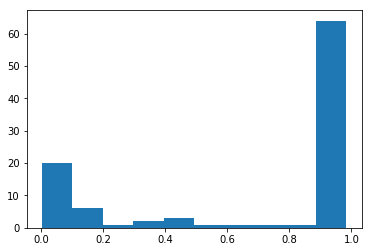

In [11]:
plt.hist(prediction[:,cat_n])

In [12]:
s0 = sample[0][prediction[:, cat_n]>0.5]
s1 = sample[1][prediction[:, cat_n]>0.5]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0., 64.]),
 array([0.5808971 , 0.62122005, 0.661543  , 0.701866  , 0.74218893,
        0.78251183, 0.8228348 , 0.86315775, 0.9034807 , 0.94380367,
        0.9841266 ], dtype=float32),
 <a list of 10 Patch objects>)

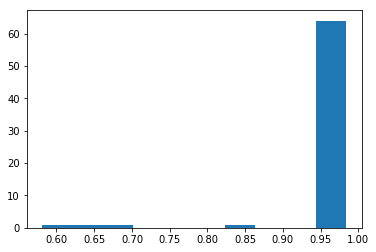

In [13]:
plt.hist(prediction[:,cat_n])

Show some instance

15
pdf


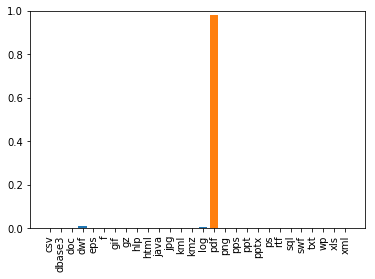

In [14]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

15
pdf


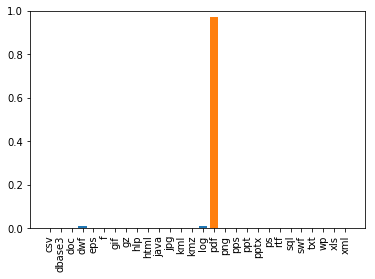

In [15]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

15
pdf


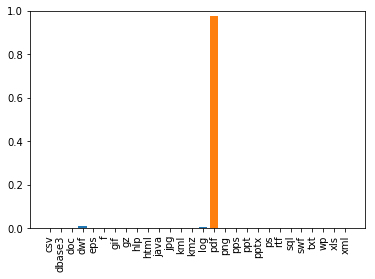

In [16]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

15
pdf


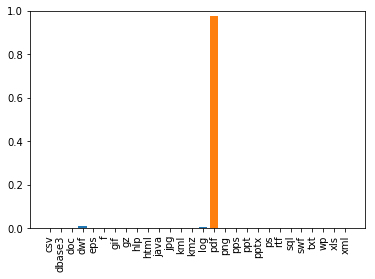

In [17]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)

#### Select the 'jpg' category

In [20]:
by_category = rawset.by_category()
batch_size = 100
cat = 'jpg'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerFirstBlock(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

Pick a sample batch

In [21]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 3.,  1.,  3.,  0.,  2.,  1.,  0.,  3., 12., 75.]),
 array([2.1549514e-04, 9.9832065e-02, 1.9944865e-01, 2.9906520e-01,
        3.9868179e-01, 4.9829835e-01, 5.9791493e-01, 6.9753152e-01,
        7.9714805e-01, 8.9676464e-01, 9.9638122e-01], dtype=float32),
 <a list of 10 Patch objects>)

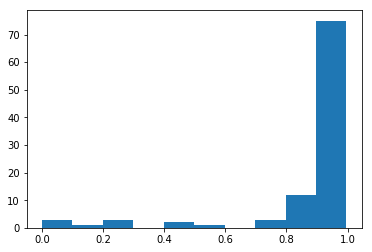

In [22]:
plt.hist(prediction[:,cat_n])

In [23]:
s0 = sample[0][prediction[:, cat_n]>0.5]
s1 = sample[1][prediction[:, cat_n]>0.5]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 1.,  0.,  0.,  2.,  1.,  3.,  3.,  8., 53., 20.]),
 array([0.5855219 , 0.62660784, 0.66769373, 0.7087797 , 0.7498656 ,
        0.79095155, 0.8320375 , 0.8731234 , 0.91420937, 0.95529526,
        0.9963812 ], dtype=float32),
 <a list of 10 Patch objects>)

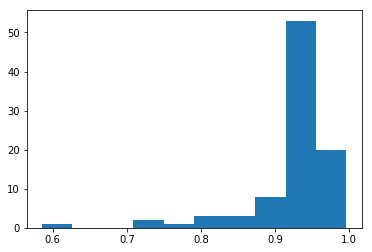

In [24]:
plt.hist(prediction[:,cat_n])

Show some instance

11
jpg


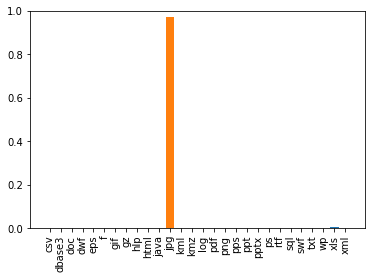

In [25]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

11
jpg


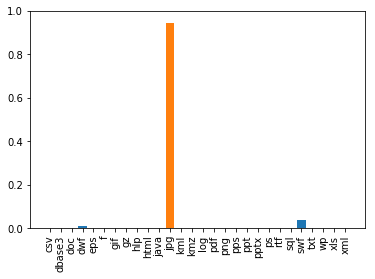

In [26]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

11
jpg


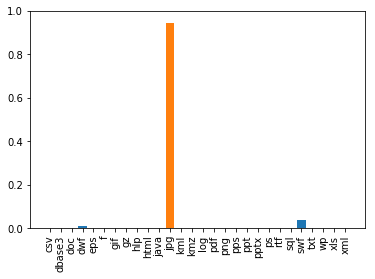

In [27]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

11
jpg


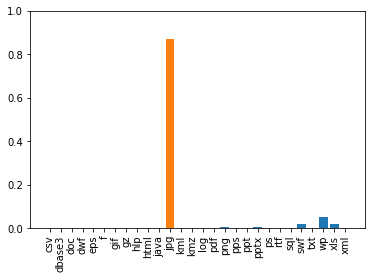

In [28]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)